In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch.nn.functional as F
import torch

from common import metrics

/home/liam/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
from typing import Tuple
from torch import Tensor
import numpy as np
import torch
import torch.nn.functional as F


@torch.no_grad()
def fill_tolerance(labels: Tensor, tolerance: int) -> Tensor:
    ws = (1, 1, 2 * tolerance + 1)
    fl_labs = labels.clone().float()
    ones = torch.ones(ws).to(fl_labs)
    full = F.conv1d(fl_labs.unsqueeze(1), ones, padding="same")
    full = (full.squeeze(1) > 0).to(labels)
    return full


def errors_curve(
    y_score: Tensor, y_true: Tensor, tolerance: int, num_thrs: int = 100
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    y_true_full = fill_tolerance(y_true, tolerance)

    mn, mx = y_score.min(), y_score.max()
    step = (mx - mn) / num_thrs
    thrs = np.arange(mn, mx, step)

    fps = []
    fns = []
    for th in thrs:
        preds: Tensor = (y_score > th).to(y_true)
        preds_full = fill_tolerance(preds, tolerance)
        fps.append(((1 - y_true_full) * preds).sum().item())
        fns.append((y_true * (1 - preds_full)).sum().item())

    fps = np.asarray(fps)
    fns = np.asarray(fns)

    return fps, fns, thrs

In [4]:
bs = 8
wl = 1024
winsize = 12
signals = torch.rand(bs, wl)
gt_labels = (torch.rand_like(signals) > 0.7).to(torch.int).to(torch.device("cuda"))

n_t = 100


def cm_win():
    fp, fn, th = metrics.errors_curve(signals, gt_labels, winsize, n_t)
    metrics.plot_errors_curve(fp, fn, th)

def cm_win_2():
    fp, fn, th = errors_curve(signals, gt_labels, winsize, n_t)
    metrics.plot_errors_curve(fp, fn, th)

In [5]:
%%timeit
fp, fn, th = metrics.errors_curve(signals, gt_labels, winsize, n_t)

6.53 ms ± 221 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%%timeit
fp, fn, th = errors_curve(signals, gt_labels, winsize, n_t)

72.4 ms ± 5.91 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


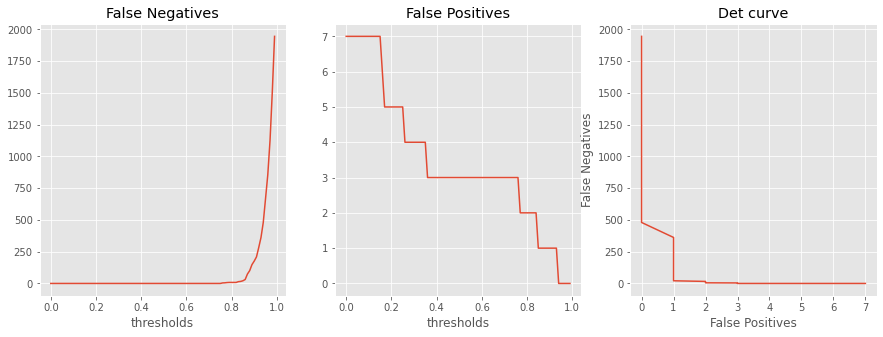

In [7]:
cm_win()

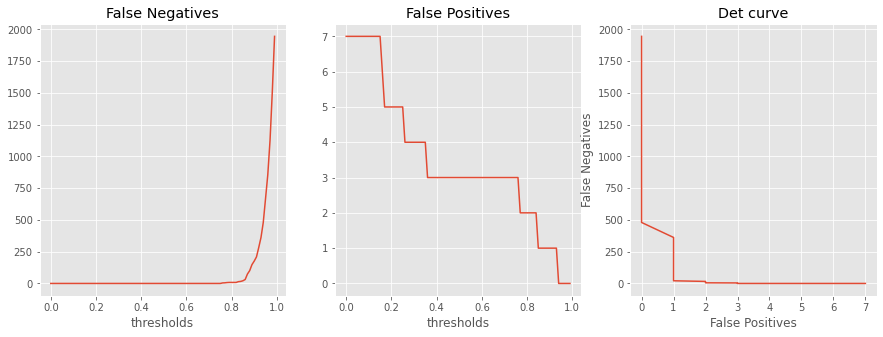

In [8]:
cm_win_2()

In [9]:
import gc

gc.collect()

19394

In [1]:
from common import data
from common.models import resnet, deeplab
import torch

device = torch.device("cuda")
backbone = resnet.ResNetFeatures(
    resnet.Bottleneck,
    resnet.RESNET50_LAYERS,
    data.NUM_FEATURES,
    [resnet.LAYER_1, resnet.LAYER_4],
    replace_stride_with_dilation=[False, True, True],
).to(device)

model = deeplab.DeepLabNet(backbone, [256, 2048], 1).to(device)


/home/liam/.local/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [4]:
bs = 8
wl = 1024
ins = torch.rand(bs, wl, data.NUM_FEATURES).to(device)

In [5]:
outs = backbone(ins.transpose(-2, -1))

In [6]:
for l, o in outs.items():
    print(l, o.size())

layer1 torch.Size([8, 256, 512])
layer4 torch.Size([8, 2048, 256])


In [7]:
outs = model(ins)
outs.size()

torch.Size([8, 1024, 1])

In [25]:
from torch.utils.data import Subset
from common import data
from typing import List
import random

def split_dataset(x: data.UnfoldedDataset, k: int) -> List:
    end = False
    step = 0
    start = random.randint(0, len(x) - 1)
    subsets = []
    l = list(range(len(x)))
    l_bool = [False for elem in l]
    
    while not end:
        # if there are enough indexes to make up another subset, make it
        if l_bool.count(False) >= int(len(l) / k):
            l_sub = []
            while len(l_sub) < int(len(l) / k):
                idx = (start + step) % len(l)
                l_sub.append(l[idx])
                l_bool[idx] = True
                step += 1
            subsets.append(l_sub)
        else:
            # if there are still indexes that haven't been assigned
            l_sub_last = []
            while l_bool.count(False) > 0:
                idx = (start + step) % len(l)
                l_sub_last.append(l[idx])
                l_bool[idx] = True
                step += 1
            subsets.append(l_sub_last)
            if len(l_sub_last) < 10:
                # if the last sublist is too short merge it with the last one
                merged_sub = subsets[-2] + subsets[-1]
                subsets.pop(-1)
                subsets.pop(-2)
                subsets.append(merged_sub)
            end = True
    return subsets

In [17]:
int(1024/5)

204

In [18]:
from sklearn.model_selection import train_test_split

paths = data.get_dataset_paths("../data")
train, test = train_test_split(paths, test_size=0.1, random_state=42)

In [7]:
horizon = 1024
stride = 512

m_data_test = data.Marconi100Dataset(test, scaling=data.Scaling.MINMAX)

Loading: 100%|██████████████████████████████████| 25/25 [03:02<00:00,  7.31s/it]


In [8]:
unf_data = data.UnfoldedDataset(m_data_test, horizon=horizon, stride=stride)

In [9]:
type(unf_data[0]["data"])

torch.Tensor

In [10]:
len(unf_data[0]["data"])

1024

In [11]:
print(unf_data[0]["data"].shape, unf_data[0]["label"].shape)

torch.Size([1024, 460]) torch.Size([1024])


In [12]:
res = torch.cat([unf_data[0]["data"], unf_data[0]["label"].reshape(-1,1)], axis=1)
print(res.shape)

torch.Size([1024, 461])


In [26]:
subsets = split_dataset(unf_data[0]["data"], 6)

In [27]:
print(len(subsets))

6


In [28]:
print(len(subsets[0]), len(subsets[-1]))

170 174


In [78]:
l = list(range(10))

In [79]:
subsets = split_dataset(l, 3)

In [80]:
subsets

[[0, 1, 2], [6, 7, 8], [6, 7, 8, 9]]

In [81]:
subsets = split_dataset(l, 3)

In [82]:
print(subsets)

[[0, 1, 2], [6, 7, 8], [6, 7, 8, 9]]
